# Higgs Boson Analysis with ATLAS Open Data
This is an example analysis of the Higgs boson detection via the decay channel H &rarr; ZZ* &rarr; 4l  
From the decay products measured at the ATLAS experiment and provided as open data, you will be able to produce a histogram, and from there you can infer the invariant mass of the Higgs boson.  
Code: it is based on the original work at [ATLAS outreach notebooks](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/tree/master/13-TeV-examples/uproot_python)  
Data: from the 13TeV [ATLAS opendata](http://opendata.atlas.cern/release/2020/documentation/datasets/files.html)  
Physics: See ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
March, 2022

## H &rarr; ZZ* &rarr; 4l analsys

In [ ]:
# Run this if you need to install Apache Spark (PySpark)

# !pip install pyspark

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

#import findspark
# findspark.init("/home/luca/Spark/spark-3.2.1-bin-hadoop3.2")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("H_ZZ_4Lep")
         .master("local[*]")
         .config("spark.driver.memory", "2g")
         .getOrCreate()
        )

In [3]:
# Run this to download the dataset 
# It is a small file (200 KB), this exercise is meant mostly to show the Spark API
# See further details at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

!wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/Data_4lep.parquet


In [4]:
# Read data with the candidate events
df_events = spark.read.parquet("Data_4lep.parquet")

df_events.printSchema()


root
 |-- runNumber: integer (nullable = true)
 |-- eventNumber: integer (nullable = true)
 |-- channelNumber: integer (nullable = true)
 |-- mcWeight: float (nullable = true)
 |-- scaleFactor_PILEUP: float (nullable = true)
 |-- scaleFactor_ELE: float (nullable = true)
 |-- scaleFactor_MUON: float (nullable = true)
 |-- scaleFactor_PHOTON: float (nullable = true)
 |-- scaleFactor_TAU: float (nullable = true)
 |-- scaleFactor_BTAG: float (nullable = true)
 |-- scaleFactor_LepTRIGGER: float (nullable = true)
 |-- scaleFactor_PhotonTRIGGER: float (nullable = true)
 |-- trigE: boolean (nullable = true)
 |-- trigM: boolean (nullable = true)
 |-- trigP: boolean (nullable = true)
 |-- lep_n: long (nullable = true)
 |-- lep_truthMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_trigMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- le

In [5]:
# Count the number of events before cuts (filter)
print(f"Number of events: {df_events.count()}")

Number of events: 832


### Apply basic cuts
More details on the cuts (filters applied to the event data) in the reference ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

In [7]:
# Apply filters to the input data
# only events with 4 leptons in the input data

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
df_events = df_events.filter("lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] == 0")

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
df_events = df_events.filter("lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3] in (44, 48, 52)")

print(f"Number of events after applying cuts: {df_events.count()}")

Number of events after applying cuts: 507


### Compute the invariant mass
This computes the 4-vectors sum for the 4-lepton system
using formulas from special relativity.  
See also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
and https://en.wikipedia.org/wiki/Invariant_mass

In [8]:
# This computes the 4-vectors sum for the 4-lepton system

df_4lep = df_events.selectExpr(
"lep_pt[0] * cos(lep_phi[0]) + lep_pt[1] * cos(lep_phi[1]) + lep_pt[2] * cos(lep_phi[2]) + lep_pt[3] * cos(lep_phi[3]) as Px",
"lep_pt[0] * sin(lep_phi[0]) + lep_pt[1] * sin(lep_phi[1]) + lep_pt[2] * sin(lep_phi[2]) + lep_pt[3] * sin(lep_phi[3]) as Py",
"lep_pt[0] * sinh(lep_eta[0]) + lep_pt[1] * sinh(lep_eta[1]) + lep_pt[2] * sinh(lep_eta[2]) + lep_pt[3] * sinh(lep_eta[3]) as Pz",
"lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] as E"    
)

df_4lep.show(5)

df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz))/1e3 as invmass_GeV")

df_4lep_invmass.show(5)

+-------------------+-------------------+-------------------+---------+
|                 Px|                 Py|                 Pz|        E|
+-------------------+-------------------+-------------------+---------+
| -5549.313396878235|-170444.05334022344|-15746.091731533503|309954.88|
|  42207.49382671445| 130573.00201274469| -47275.43779472515|294242.06|
|-1688.5786930973281| 12019.559647988772|-184350.58119043778|255493.97|
|-24986.255307382246| -16563.56023125274|  586515.1288275808| 655824.6|
| -25158.89812267374|-26052.317345542066|  649866.7138738859| 689542.3|
+-------------------+-------------------+-------------------+---------+
only showing top 5 rows

+------------------+
|       invmass_GeV|
+------------------+
| 258.3449524588402|
| 255.9543720735489|
| 176.4786439391845|
| 291.9028801340375|
|227.66237283516355|
+------------------+
only showing top 5 rows



In [9]:
# Compute the histogram of invariant mass
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 80
max_val = 250
num_bins = (max_val - min_val) / 5.0
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_4lep_invmass
        .selectExpr(f"width_bucket(invmass_GeV, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding center value of the histogram
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")

In [10]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 267 ms, sys: 43.1 ms, total: 310 ms
Wall time: 1.09 s


In [11]:
import numpy as np

# Computes statistical error on the data (histogram)
histogram_data_stat_errors = np.sqrt(histogram_data_pandas)

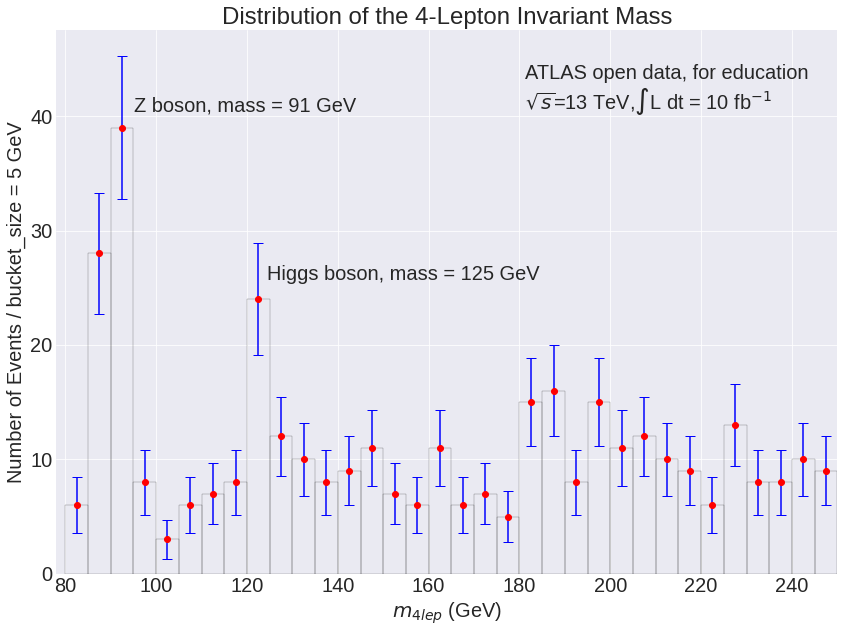

In [12]:
# This plots the data histogram with error bars

import matplotlib.pyplot as plt 

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]
err = histogram_data_stat_errors[1:-1]["N_events"]

# scatter plot
ax.plot(x, y, marker='o', color='red', linewidth=0)
#ax.errorbar(x, y, err, fmt = 'ro')
# histogram with error bars
ax.bar(x, y, width = 5.0, yerr = err, capsize = 5, linewidth = 0.2, ecolor='blue', fill=False)

ax.set_xlim(min_val-2, max_val)

ax.set_xlabel('$m_{4lep}$ (GeV)')
ax.set_ylabel('Number of Events / bucket_size = 5 GeV')
ax.set_title("Distribution of the 4-Lepton Invariant Mass")

# Label for the Z ang Higgs spectrum peaks
txt_opts = {'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.10, 0.86, "Z boson, mass = 91 GeV", **txt_opts)
plt.text(0.27, 0.55, "Higgs boson, mass = 125 GeV", **txt_opts)

# Add energy and luminosity
plt.text(0.60, 0.92, "ATLAS open data, for education", **txt_opts)
plt.text(0.60, 0.87, '$\sqrt{s}$=13 TeV,$\int$L dt = 10 fb$^{-1}$', **txt_opts)

plt.show()

In [11]:
spark.stop()